# Verify behavior cloning

Visually verify a behavior cloning based robot controller.

* Load the controller trained by the Train_BC notebook and the corresponding sp
* Choose a demonstration, to which the SP/BC pair will be applied to the images
* Visualize the path taken by the demonstration and what would be (autoregressively) recommended by the controller

In [ ]:
import sys
sys.path.append("..")

from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import pathlib
import pprint
import matplotlib.pyplot as plt
# fixing the fact that it defaults to Type 3 fonts
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import torch
# import torch.nn as nn
# import torch.optim as optim
import numpy as np

from bc_factory import create_bc_model
# FIXME: factor this out
from bc_LSTM_MDN import bc_LSTM_MDN, mdn_loss

torch.manual_seed(1)
from sensorprocessing.sp_helper import get_transform_to_sp
from sensorprocessing.sp_factory import create_sp
from demonstration.demonstration import Demonstration

from robot.al5d_position_controller import RobotPosition
import bc_factory 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.13_3.13.2032.0_x64__qbz5n2kfra8p0\Lib\pathlib\__init__.py
***ExpRun**: Loading pointer config file:
	C:\Users\lotzi\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	c:\Users\lotzi\Work\_Config\BerryPicker\cfg\settings.yaml
Using device: cuda


In [2]:
# *** Initialize the variables with default values 
# *** This cell should be tagged as parameters     
# *** If papermill is used, some of the values will be overwritten 

# If it is set to true, the exprun will be recreated from scratch
creation_style = "exist-ok"

# If not None, set an external experiment path
external_path = None

# If not None, set an output path
data_path = None



experiment = "behavior_cloning"
# run = "bc_verify_mlp_00"
# run = "bc_verify_lstm_00"
# run = "bc_verify_lstm_resid_00"
run = "bc_verify_lstm_mdn_00"

# Running a particular model 
external_path = pathlib.Path('C:/Users/lotzi/Work/_DataExternal/BerryPicker-BC/exprun')
data_path = pathlib.Path('C:/Users/lotzi/Work/_DataExternal/BerryPicker-BC/result')
run = "bc_mlp_0001_verify"



In [ ]:
if external_path:
    external_path = pathlib.Path(external_path)
    assert external_path.exists()
    Config().set_exprun_path(external_path)
    Config().copy_experiment("sensorprocessing_conv_vae")
    Config().copy_experiment("robot_al5d")
    Config().copy_experiment("demonstration")
    Config().copy_experiment("behavior_cloning")
if data_path:
    data_path = pathlib.Path(data_path)
    assert data_path.exists()
    Config().set_results_path(data_path)
    
# temporary solution
# Setting up a separate directory for generated and computed data

exp = Config().get_experiment(experiment, run, creation_style=creation_style)
pprint.pprint(exp)

# Create the sp object described in the experiment
exp_sp = Config().get_experiment(exp["exp_sp"], exp["run_sp"])
sp = create_sp(exp_sp, device)
transform = get_transform_to_sp(exp_sp)

exp_robot = Config().get_experiment(exp["exp_robot"], exp["run_robot"])

# Load the bc model described in the experiment
exp_bc = Config().get_experiment(exp["exp_bc"], exp["run_bc"])
model, _, _ = create_bc_model(exp_bc, exp_sp, device)
model_path = pathlib.Path(exp_bc.data_dir(), exp_bc["controller_file"])
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))   
# model.load_state_dict(torch.load(model_path))

***ExpRun**: Experiment config path changed to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\exprun
***ExpRun**: Experiment sensorprocessing_conv_vae copied to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\exprun\sensorprocessing_conv_vae
***ExpRun**: Experiment robot_al5d copied to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\exprun\robot_al5d
***ExpRun**: Experiment demonstration copied to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\exprun\demonstration
***ExpRun**: Experiment behavior_cloning copied to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\exprun\behavior_cloning
***ExpRun**: Experiment data path changed to C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\result
***ExpRun**: Configuration for exp/run: behavior_cloning/bc_mlp_0001_verify successfully loaded
Experiment:
    batch_size: 64
    control_size: 6
    data_dir: C:\Users\lotzi\Work\_DataExternal\BerryPicker-BC\result\behavior_cloning\bc_mlp_0001_verify
    epochs: 10
    exp_bc: behavior_cloning
   

<All keys matched successfully>

In [4]:
pred_path = pathlib.Path(exp.data_dir(), "pred.npy")
real_path = pathlib.Path(exp.data_dir(), "real.npy")

if pred_path.exists():
    a_pred_np = np.load(pred_path)
    a_real_np = np.load(real_path)
    print(f"Paths successfully loaded from\n{pred_path.relative_to(pathlib.Path.home())}")
else:
    a_real_list = []
    a_pred_list = []
    with torch.no_grad(): # disable gradient computation
        for val in exp["verification_data"]: # for all demonstrations
            run, demo_name, camera = val
            exp_demo = Config().get_experiment("demonstration", run)
            demo = Demonstration(exp_demo, demo_name)
            for i in range(demo.metadata["maxsteps"]-exp_bc["sequence_length"]): # -1 because of lookahead
                if exp_bc["sequence_length"]:
                    input_list = []
                    # FIXME make it sliding window
                    for j in range(exp_bc["sequence_length"]):
                        sensor_readings, _ = demo.get_image(i+j, device=device, transform=transform, camera=camera)
                        if sensor_readings is not None:
                            print(f"reading {i+j} successful")
                        else:
                            print(f"reading {i+j} not successful, returned none")
                        z = sp.process(sensor_readings)
                        input_list.append(z)
                        input_nd = np.array(input_list)
                        z_tensor = torch.tensor(input_nd).unsqueeze(0).to(device)
                else:
                    sensor_readings, _ = demo.get_image(i, device=device, transform=transform, camera=camera)
                    z = sp.process(sensor_readings)
                    z_tensor = torch.tensor(z).unsqueeze(0).to(device)
                if not isinstance(model, bc_LSTM_MDN):                
                    a_pred = model(z_tensor)
                else:
                    a_pred = model.forward_and_sample(z_tensor)
                a_pred_list.append(a_pred.to("cpu").squeeze(0))
                a = demo.get_action(i)
                rp = RobotPosition.from_vector(exp_robot, a)
                a_real = rp.to_normalized_vector(exp_robot)            
                a_real_list.append(a_real)
    a_pred_np = np.array(a_pred_list)
    a_real_np = np.array(a_real_list)

    # save the comparison terms
    np.save(pred_path, a_pred_np)
    np.save(real_path, a_real_np)            

Paths successfully loaded from
Work\_DataExternal\BerryPicker-BC\result\behavior_cloning\bc_mlp_0001_verify\pred.npy


## Plot the differences between the a_real and a_pred

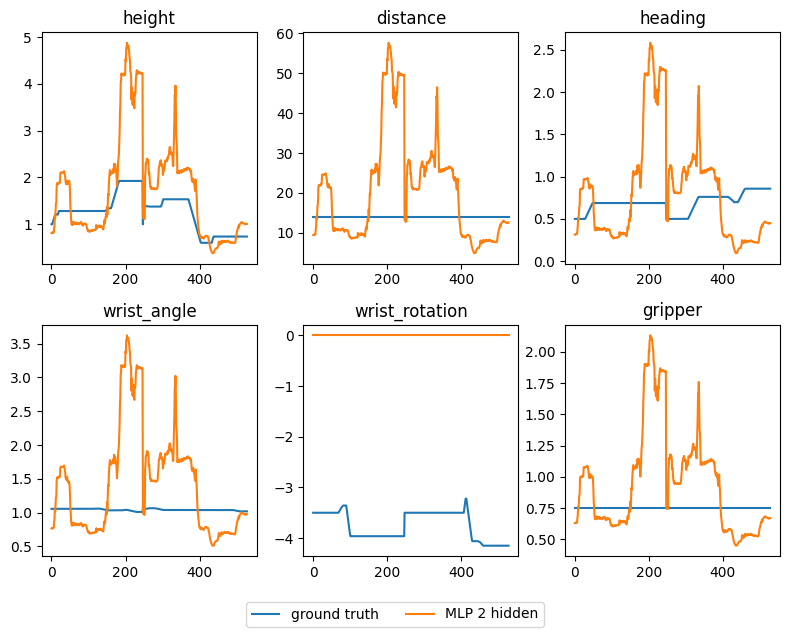

In [11]:

fig, axs = plt.subplots(2,3, figsize=(8, 6))
titles = ["height","distance", "heading", "wrist_angle", "wrist_rotation", "gripper"]
for i in range(exp_bc["control_size"]):
    ax = axs[i//3, i%3]
    #ax.set_ylim(0, 1.4)
    ax.plot(a_real_np[:,i], label="ground truth")
    if len(a_pred_np.shape) == 3:
        ax.plot(a_pred_np[:,0,i], label=exp_bc["name"])
    else:
        ax.plot(a_pred_np[:,i], label=exp_bc["name"])
    if i==0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, ncol=2,
            bbox_to_anchor=(0.5, 0), loc="upper center")
    ax.set_title(titles[i])

plt.tight_layout()
graphfilename = pathlib.Path(exp.data_dir(), "bccomparison.pdf")
plt.savefig(graphfilename, bbox_inches='tight')

In [8]:
# print(exp_bc)

a_real_np.shape
# a_real_np[:,1]

(529, 6)

In [10]:
len(a_pred_np.shape)

3

In [ ]:
exp_bc